In [9]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from scipy.stats import describe


import matplotlib.colors as colors
import kerastuner as kt

from scipy import signal

from scipy.stats import probplot
from scipy.stats import normaltest


from joblib import dump, load

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
from ML_Train.CNN_Classifier import  build_classifier_from_vae, create_vae, create_classifier
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [10]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [11]:
def extract_features(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
#     amps /= 0.01
    amps = lin_log_interp(amps)
    
    _,minmax,mean,variance,skewness,kurtosis = describe(values,axis=1)
    mean = mean[...,np.newaxis]
    variance = variance[...,np.newaxis]
    skewness = skewness[...,np.newaxis]
    kurtosis = kurtosis[...,np.newaxis]
    
    sampleRMS = np.sqrt(1 / values.shape[0] * np.sum((values - np.repeat(mean,values.shape[1],axis=1).reshape(mean.shape[0],values.shape[1]))**2,axis=1))
    sampleRMS = sampleRMS[...,np.newaxis]
    
    print(mean.shape,variance.shape,skewness.shape,kurtosis.shape,sampleRMS.shape)
    

    stats = np.hstack((mean,variance,skewness,kurtosis,sampleRMS))
        
    return amps,stats
def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [12]:

DoE_test = np.loadtxt('Experiment-3-Data/DoE_test_pruned.txt',delimiter=',')
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

In [68]:
DoE_test = np.loadtxt('Experiment-3-Data/DoE_test_pruned.txt',delimiter=',')
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train_original,stats_train_original = extract_features(X_train,)
X_test_original,stats_test_original = extract_features(X_test,)

stats_train_unhealthy = stats_train_original[first_good_train:,:]
stats_valid_unhealthy = stats_test_original[first_good_test:,:]
stats_train_healthy = stats_train_original[:first_good_train,:]
stats_valid_healthy = stats_test_original[:first_good_test,:]


X_train_unhealthy = X_train_original[first_good_train:,:]
X_valid_unhealthy = X_test_original[first_good_test:,:]
X_train_healthy = X_train_original[:first_good_train,:]
X_valid_healthy = X_test_original[:first_good_test,:]

DoE_train_healthy = DoE_train[:first_good_train,:]
DoE_train_unhealthy = DoE_train[first_good_train:,:]
DoE_test_healthy = DoE_test[:first_good_test,:]
DoE_test_unhealthy = DoE_test[first_good_test:,:]


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

stats_train = np.vstack((stats_train_healthy,stats_train_unhealthy))
stats_valid = np.vstack((stats_valid_healthy,stats_valid_unhealthy))

Y_train = XY_train[:,-1]
Y_valid = XY_valid[:,-1]
columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']

X = []
X.append(X_train_healthy)
X.append(X_valid_healthy)
X.append(X_train_unhealthy)
X.append(X_valid_unhealthy)

DoE = []
DoE.append(DoE_train_healthy)
DoE.append(DoE_test_healthy)
DoE.append(DoE_train_unhealthy)
DoE.append(DoE_test_unhealthy)

stats = []
stats.append(stats_train_healthy)
stats.append(stats_valid_healthy)
stats.append(stats_train_unhealthy)
stats.append(stats_valid_unhealthy)
freqs = np.linspace(0,10000,2048)


(306, 1) (306, 1) (306, 1) (306, 1) (306, 1)
(151, 1) (151, 1) (151, 1) (151, 1) (151, 1)


In [14]:
def plot_confusion_matrix(y_true,y_pred,
                          labels,
                          filename='confusion_matrix'):
    
    predict_label = labels
    true_label = labels.copy()
    
    
    predict_label.insert(0, '')

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    false_positive = conf_matrix[0,1]
    false_negative = conf_matrix[1,0]
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2

    fig = plt.figure()
    ax = plt.gca()
    im = ax.matshow(conf_matrix,cmap='gray',norm=colors.Normalize(vmin=0.,vmax=.5))

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true_label)
    ax.set_yticklabels(predict_label)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    xlabel = 'Actual State'
    ylabel = 'Predicted State'
    xlabelpad = 5

    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad)
    plt.ylabel(r'\textbf{' + ylabel + '}', labelpad=5)

    # Loop over data dimensions and create text annotations.
    for i in range(len(predict_label)-1):
        for j in range(len(true_label)):
            text_color = 'w'
            if conf_matrix[i,j] > 0.25:
                text_color = 'k'
            text = ax.text(j, i, r'\textbf{' + str(conf_matrix[i, j]) + '}',fontsize=22,
                           ha="center", va="center", color=text_color)

    cbar = plt.colorbar(im)
    cbar.set_label(r'\textbf{Occurrence Fraction}', rotation=270,labelpad=20)
    plt.tight_layout()
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    
    return balanced_accuracy, true_positive_rate, true_negative_rate

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC

In [11]:
def normalize_scores(scores,log_prob=False):
    
    if log_prob:
        scores = np.log(np.abs(scores - 1.1 * np.amax(scores)))
    
    norm_mean = np.mean(scores[:,0])
    norm_std = np.std(scores[:,0])
    
    scores = (scores - norm_mean) / norm_std
    
    [print(normaltest(scores[:,i])) for i in range(scores.shape[1])]
    [print(np.std(scores[:,i]), np.mean(scores[:,i])) for i in range(scores.shape[1])]
    
    return scores

In [12]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

NameError: name 'Y_cnn_valid_pred' is not defined

In [15]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization

from ML_Train.Custom_Layers import Dropout_Live

def build_hp_classifier(hp):
    
    mlp = Sequential()
    mlp.add(Input(shape=max_fft + DoE_shape))
    mlp.add(Flatten())
    
    for i in range(hp.Int('hidden_layers', 2, 5, step=1)):
        mlp.add(Dense(hp.Int('filters_' + str(i), 8, 256, step=8), activation='relu'))
        mlp.add(BatchNormalization())
        mlp.add(Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1)))
        
    mlp.add(Dense(2,activation='softmax'))
    
    mlp.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
        
    return mlp

In [16]:
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)


tuner = kt.Hyperband(
    build_hp_classifier,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=4,
    directory='mlp_fft_classifier',
    project_name='mlp_fft_classifier')

tuner.search(X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
             validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Reloading Oracle from existing project mlp_fft_classifier/mlp_fft_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from mlp_fft_classifier/mlp_fft_classifier/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [17]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]


In [18]:

loss = model.fit(
            X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
            validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
            epochs=40,
            verbose=1)

Y_mlp_valid_pred = model.predict(X_valid)
Y_mlp_train_pred = model.predict(X_train)

Y_mlp_train_pred = np.argmax(Y_mlp_train_pred,axis=1)
Y_mlp_valid_pred = np.argmax(Y_mlp_valid_pred,axis=1)

Train on 306 samples, validate on 151 samples
Epoch 1/40
306/306 [==============================] - ETA: 5s - loss: 1.0995 - accuracy: 0.43 - 1s 3ms/sample - loss: 0.7873 - accuracy: 0.6601 - val_loss: 0.7093 - val_accuracy: 0.4106
Epoch 2/40
306/306 [==============================] - ETA: 0s - loss: 0.9536 - accuracy: 0.68 - 0s 188us/sample - loss: 0.5877 - accuracy: 0.7222 - val_loss: 0.9485 - val_accuracy: 0.4172
Epoch 3/40
306/306 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.87 - 0s 187us/sample - loss: 0.4600 - accuracy: 0.7908 - val_loss: 1.1322 - val_accuracy: 0.4702
Epoch 4/40
306/306 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.84 - 0s 174us/sample - loss: 0.3207 - accuracy: 0.8464 - val_loss: 1.2834 - val_accuracy: 0.4768
Epoch 5/40
306/306 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.93 - 0s 193us/sample - loss: 0.2388 - accuracy: 0.8922 - val_loss: 1.7244 - val_accuracy: 0.4834
Epoch 6/40
306/3

In [19]:

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 131)               0         
_________________________________________________________________
dense (Dense)                (None, 248)               32736     
_________________________________________________________________
batch_normalization (BatchNo (None, 248)               992       
_________________________________________________________________
dropout (Dropout)            (None, 248)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               25896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 104)               416       
_________________________________________________________________
dropout_1 (Dropout)          (None, 104)               0

No handles with labels found to put in legend.


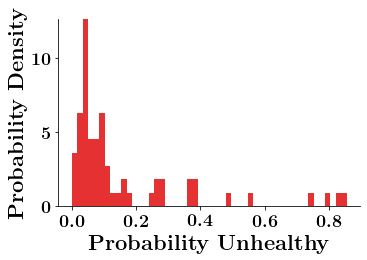

No handles with labels found to put in legend.


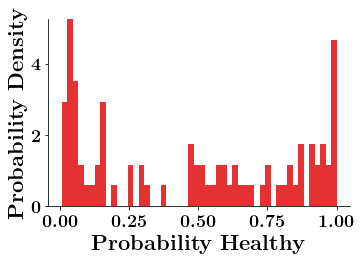

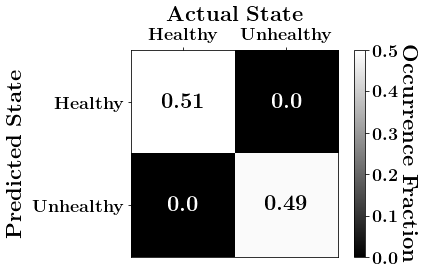

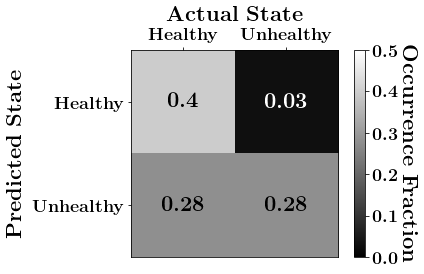

(1.0, 1.0, 1.0)
(0.74573055028463, 0.5882352941176471, 0.9032258064516129)


In [20]:
genplt.plot_histogram(model.predict(X_valid_unhealthy)[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy)[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_mlp_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_mlp_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [21]:

conf_matrix_mlp_valid = confusion_matrix(Y_valid, Y_mlp_valid_pred)
accuracy_mlp_valid = np.sum(np.diagonal(conf_matrix_mlp_valid)) / np.sum(conf_matrix_mlp_valid)
print(conf_matrix_mlp_valid)
print(accuracy_mlp_valid)

conf_matrix_mlp_train = confusion_matrix(Y_train, Y_mlp_train_pred)
accuracy_mlp_train = np.sum(np.diagonal(conf_matrix_mlp_train)) / np.sum(conf_matrix_mlp_train)
print(conf_matrix_mlp_train)
print(accuracy_mlp_train)

[[60  5]
 [43 43]]
0.6821192052980133
[[156   0]
 [  0 150]]
1.0


In [23]:
np.argwhere(freqs > 2000)


In [41]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   hp
                   ):
    inputs = Input(shape=(max_fft + DoE_shape,1))
    x = inputs
    
    for i in range(hp.Int('filters', 2, 5, step=1)):
        x = Conv1D(filters=hp.Int('filters_' + str(i), 4, 64, step=4), 
                           kernel_size=hp.Int('kernels_' + str(i), 3, 19, step=4), 
                           strides=1, 
                           activation='relu', 
                           padding='same',
                           dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1))(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(hp.Int('dense_layers', 1, 1, step=1)):
        x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='selu')(x)

    x = Dense(2,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    cnn_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
     
    
    return cnn_classifier


In [69]:
max_fft = 308
DoE_shape = 0
stats_shape = 0

X_train = np.hstack((XY_train[:,:max_fft],XY_train[:,-1][...,np.newaxis]))
X_valid = np.hstack((XY_valid[:,:max_fft],XY_valid[:,-1][...,np.newaxis]))

np.random.shuffle(X_train)
np.random.shuffle(X_valid)

Y_train = X_train[:,-1]
Y_valid = X_valid[:,-1]

X_train = X_train[:,:-1]
X_valid = X_valid[:,:-1]



tuner = kt.Hyperband(
    build_classifier,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    directory='cnn_fft_classifier',
    project_name='cnn_fft_classifier')

tuner.search(X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
             validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 2.3815 - accuracy: 0.40 - 1s 2ms/sample - loss: 3.8331 - accuracy: 0.5980 - val_loss: 3.6270 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.62 - 0s 164us/sample - loss: 0.4799 - accuracy: 0.7647 - val_loss: 2.7290 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 0.9950 - accuracy: 0.56 - 1s 4ms/sample - loss: 0.8304 - accuracy: 0.5752 - val_loss: 0.7008 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.68 - 0s 256us/sample - loss: 0.5250 - accuracy: 0.7451 - val_loss: 0.6824 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.3206 - accuracy: 0.50 - 1s 3ms/sample - loss: 2.7532 - accuracy: 0.6078 - val_loss: 2.0371 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.81 - 0s 195us/sample - loss: 0.7134 - accuracy: 0.8072 - val_loss: 1.6820 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.5467 - accuracy: 0.56 - 1s 3ms/sample - loss: 3.5869 - accuracy: 0.5327 - val_loss: 2.7942 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7314 - accuracy: 0.75 - 0s 216us/sample - loss: 0.3396 - accuracy: 0.8562 - val_loss: 3.9892 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.8665 - accuracy: 0.46 - 1s 4ms/sample - loss: 0.9958 - accuracy: 0.6013 - val_loss: 0.6950 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.71 - 0s 275us/sample - loss: 0.3725 - accuracy: 0.8497 - val_loss: 0.6830 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.5089 - accuracy: 0.40 - 1s 3ms/sample - loss: 4.1544 - accuracy: 0.5556 - val_loss: 3.5095 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8645 - accuracy: 0.68 - 0s 218us/sample - loss: 0.7675 - accuracy: 0.6961 - val_loss: 3.6403 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.9740 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.9858 - accuracy: 0.5556 - val_loss: 0.9300 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.78 - 0s 195us/sample - loss: 0.9430 - accuracy: 0.7386 - val_loss: 0.7482 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 0.8989 - accuracy: 0.53 - 2s 5ms/sample - loss: 0.7429 - accuracy: 0.5752 - val_loss: 0.6896 - val_accuracy: 0.5762
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7776 - accuracy: 0.62 - 0s 235us/sample - loss: 0.7160 - accuracy: 0.6209 - val_loss: 0.6853 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.5441 - accuracy: 0.53 - 1s 4ms/sample - loss: 1.1877 - accuracy: 0.5359 - val_loss: 0.6937 - val_accuracy: 0.4503
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9405 - accuracy: 0.56 - 0s 227us/sample - loss: 0.7595 - accuracy: 0.6503 - val_loss: 0.6813 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.8476 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.3053 - accuracy: 0.5621 - val_loss: 0.6958 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7736 - accuracy: 0.68 - 0s 234us/sample - loss: 0.8861 - accuracy: 0.6667 - val_loss: 0.6794 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 0.8748 - accuracy: 0.50 - 1s 5ms/sample - loss: 0.7294 - accuracy: 0.5948 - val_loss: 0.6891 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7899 - accuracy: 0.46 - 0s 241us/sample - loss: 0.6855 - accuracy: 0.6078 - val_loss: 0.6859 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.5657 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.8409 - accuracy: 0.6830 - val_loss: 0.6981 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.87 - 0s 236us/sample - loss: 0.1523 - accuracy: 0.9346 - val_loss: 0.6838 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 2.1600 - accuracy: 0.46 - 2s 5ms/sample - loss: 1.3962 - accuracy: 0.5490 - val_loss: 0.6902 - val_accuracy: 0.5894
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.53 - 0s 203us/sample - loss: 0.8579 - accuracy: 0.6471 - val_loss: 0.6791 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.8956 - accuracy: 0.62 - 1s 3ms/sample - loss: 1.0470 - accuracy: 0.5817 - val_loss: 0.6949 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.75 - 0s 278us/sample - loss: 0.5154 - accuracy: 0.7647 - val_loss: 0.6800 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.4899 - accuracy: 0.46 - 1s 2ms/sample - loss: 8.9250 - accuracy: 0.5065 - val_loss: 21.3837 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.59 - 0s 151us/sample - loss: 0.6038 - accuracy: 0.5948 - val_loss: 34.5009 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.2377 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.2049 - accuracy: 0.5458 - val_loss: 0.6967 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.59 - 0s 167us/sample - loss: 1.0052 - accuracy: 0.5980 - val_loss: 0.6985 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 9s - loss: 1.6219 - accuracy: 0.53 - ETA: 0s - loss: 1.1082 - accuracy: 0.54 - 2s 5ms/sample - loss: 1.0987 - accuracy: 0.5588 - val_loss: 0.6826 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1028 - accuracy: 0.56 - ETA: 0s - loss: 0.8630 - accuracy: 0.62 - 0s 274us/sample - loss: 0.8368 - accuracy: 0.6340 - val_loss: 0.6916 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.9328 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.6416 - accuracy: 0.4869 - val_loss: 0.6843 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 2.1184 - accuracy: 0.53 - 0s 204us/sample - loss: 1.4225 - accuracy: 0.5621 - val_loss: 0.6866 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.8962 - accuracy: 0.59 - 1s 4ms/sample - loss: 0.6928 - accuracy: 0.6895 - val_loss: 0.6911 - val_accuracy: 0.4636
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.84 - 0s 240us/sample - loss: 0.4827 - accuracy: 0.8039 - val_loss: 0.7004 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.6088 - accuracy: 0.53 - 1s 3ms/sample - loss: 5.0160 - accuracy: 0.5490 - val_loss: 1.0622 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.4914 - accuracy: 0.59 - 0s 161us/sample - loss: 0.7632 - accuracy: 0.6503 - val_loss: 1.1833 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.7703 - accuracy: 0.59 - 1s 3ms/sample - loss: 1.1033 - accuracy: 0.4902 - val_loss: 0.7070 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.59 - 0s 209us/sample - loss: 0.9738 - accuracy: 0.4771 - val_loss: 0.7456 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9118 - accuracy: 0.62 - 1s 2ms/sample - loss: 1.8161 - accuracy: 0.6242 - val_loss: 1.0467 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.90 - 0s 170us/sample - loss: 0.1785 - accuracy: 0.9412 - val_loss: 0.8772 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 1.9863 - accuracy: 0.53 - 1s 5ms/sample - loss: 1.2067 - accuracy: 0.6307 - val_loss: 0.6877 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.71 - 0s 198us/sample - loss: 0.5908 - accuracy: 0.7647 - val_loss: 0.6953 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.7790 - accuracy: 0.71 - 1s 3ms/sample - loss: 0.9392 - accuracy: 0.6667 - val_loss: 0.6859 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.81 - 0s 216us/sample - loss: 0.4158 - accuracy: 0.8203 - val_loss: 0.6762 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.6936 - accuracy: 0.40 - 1s 2ms/sample - loss: 2.2428 - accuracy: 0.6863 - val_loss: 3.6111 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.87 - 0s 202us/sample - loss: 0.1370 - accuracy: 0.9444 - val_loss: 1.7293 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.5531 - accuracy: 0.34 - 1s 3ms/sample - loss: 1.2012 - accuracy: 0.5196 - val_loss: 0.6802 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1075 - accuracy: 0.65 - 0s 227us/sample - loss: 0.8649 - accuracy: 0.6601 - val_loss: 0.6908 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 0.9989 - accuracy: 0.62 - 1s 4ms/sample - loss: 1.0956 - accuracy: 0.5980 - val_loss: 0.6823 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.75 - 0s 216us/sample - loss: 0.4612 - accuracy: 0.8072 - val_loss: 0.7071 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.3152 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.2636 - accuracy: 0.6373 - val_loss: 0.8418 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.87 - 0s 152us/sample - loss: 0.1879 - accuracy: 0.9248 - val_loss: 1.0486 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.5393 - accuracy: 0.68 - 1s 3ms/sample - loss: 3.0646 - accuracy: 0.7157 - val_loss: 1.7183 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.87 - 0s 174us/sample - loss: 0.2743 - accuracy: 0.8987 - val_loss: 0.9940 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.8609 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.3109 - accuracy: 0.5065 - val_loss: 0.6895 - val_accuracy: 0.7351
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7739 - accuracy: 0.59 - 0s 181us/sample - loss: 0.7633 - accuracy: 0.6046 - val_loss: 0.6791 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.2922 - accuracy: 0.50 - 1s 4ms/sample - loss: 3.8130 - accuracy: 0.6536 - val_loss: 0.7956 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.87 - 0s 226us/sample - loss: 0.2612 - accuracy: 0.9281 - val_loss: 1.0095 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.9146 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.3143 - accuracy: 0.6699 - val_loss: 0.7304 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.96 - 0s 166us/sample - loss: 0.2391 - accuracy: 0.8987 - val_loss: 0.7361 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 2.6676 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.3319 - accuracy: 0.5980 - val_loss: 0.7165 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.84 - 0s 187us/sample - loss: 0.4377 - accuracy: 0.8007 - val_loss: 0.6743 - val_accuracy: 0.7219


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 9s - loss: 1.2774 - accuracy: 0.56 - 2s 6ms/sample - loss: 1.3216 - accuracy: 0.5882 - val_loss: 0.9430 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1307 - accuracy: 0.65 - 0s 239us/sample - loss: 0.6840 - accuracy: 0.7451 - val_loss: 1.1476 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.0682 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.9151 - accuracy: 0.5523 - val_loss: 0.6866 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.62 - 0s 196us/sample - loss: 0.6212 - accuracy: 0.6732 - val_loss: 0.6858 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.9839 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.8693 - accuracy: 0.6438 - val_loss: 0.8052 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.75 - 0s 152us/sample - loss: 0.2486 - accuracy: 0.8922 - val_loss: 0.9345 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.9072 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.2083 - accuracy: 0.5392 - val_loss: 0.6875 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.68 - 0s 215us/sample - loss: 0.7648 - accuracy: 0.6667 - val_loss: 0.6840 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.4890 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.0464 - accuracy: 0.5392 - val_loss: 0.6850 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8691 - accuracy: 0.53 - 0s 216us/sample - loss: 0.8114 - accuracy: 0.5556 - val_loss: 0.6841 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 0.8906 - accuracy: 0.43 - 1s 3ms/sample - loss: 0.6977 - accuracy: 0.5948 - val_loss: 0.6895 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5174 - accuracy: 0.71 - 0s 228us/sample - loss: 0.3730 - accuracy: 0.8366 - val_loss: 0.6869 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.3001 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.3334 - accuracy: 0.6078 - val_loss: 0.7022 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.6133 - accuracy: 0.50 - 0s 206us/sample - loss: 0.5645 - accuracy: 0.7778 - val_loss: 0.6966 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.5234 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.2633 - accuracy: 0.6013 - val_loss: 0.6832 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.2590 - accuracy: 0.59 - 0s 191us/sample - loss: 0.7747 - accuracy: 0.7418 - val_loss: 0.6848 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 2.2567 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.2889 - accuracy: 0.5850 - val_loss: 0.6903 - val_accuracy: 0.6159
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.65 - 0s 173us/sample - loss: 1.0501 - accuracy: 0.6471 - val_loss: 0.6841 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 6s - loss: 0.9041 - accuracy: 0.50 - 1s 3ms/sample - loss: 0.8609 - accuracy: 0.4804 - val_loss: 0.6968 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7351 - accuracy: 0.56 - 0s 304us/sample - loss: 0.7548 - accuracy: 0.4902 - val_loss: 0.6916 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 0.9215 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.6604 - accuracy: 0.7157 - val_loss: 0.6953 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.84 - 0s 224us/sample - loss: 0.1722 - accuracy: 0.9314 - val_loss: 0.6783 - val_accuracy: 0.5828


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.1643 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.2909 - accuracy: 0.5327 - val_loss: 0.6845 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.1414 - accuracy: 0.46 - 0s 220us/sample - loss: 0.9640 - accuracy: 0.4771 - val_loss: 0.6836 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 6s - loss: 1.0271 - accuracy: 0.50 - 1s 3ms/sample - loss: 0.9946 - accuracy: 0.5654 - val_loss: 0.6851 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.4875 - accuracy: 0.37 - 0s 253us/sample - loss: 0.8754 - accuracy: 0.5948 - val_loss: 0.6819 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.7814 - accuracy: 0.68 - 1s 2ms/sample - loss: 1.7057 - accuracy: 0.5327 - val_loss: 0.6845 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.8841 - accuracy: 0.75 - 0s 194us/sample - loss: 1.1616 - accuracy: 0.6307 - val_loss: 0.6786 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 1.3198 - accuracy: 0.53 - 0s 201us/sample - loss: 0.7655 - accuracy: 0.6863 - val_loss: 0.7158 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 0.8348 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.8117 - accuracy: 0.6601 - val_loss: 0.7049 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.87 - 0s 235us/sample - loss: 0.1874 - accuracy: 0.9281 - val_loss: 0.6915 - val_accuracy: 0.4901
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.93 - 0s 226us/sample - loss: 0.0786 - accuracy: 0.9739 - val_loss: 0.6799 - val_accuracy: 0.5695
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 1.00 - 0s 181us/sample - loss: 0.0301 - accuracy: 0.9935 - val_loss: 0.6894 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.7106 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.1164 - accuracy: 0.5294 - val_loss: 0.7080 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.68 - 0s 224us/sample - loss: 0.6408 - accuracy: 0.6569 - val_loss: 0.6764 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.68 - 0s 188us/sample - loss: 0.5235 - accuracy: 0.7451 - val_loss: 0.7509 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.5925 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.3443 - accuracy: 0.4967 - val_loss: 0.6957 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.9201 - accuracy: 0.68 - 0s 274us/sample - loss: 0.8429 - accuracy: 0.6732 - val_loss: 0.6928 - val_accuracy: 0.5232
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.7503 - accuracy: 0.65 - 0s 267us/sample - loss: 0.8001 - accuracy: 0.6699 - val_loss: 0.6909 - val_accuracy: 0.5497
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.93 - 0s 258us/sample - loss: 0.4673 - accuracy: 0.8039 - val_loss: 0.6858 - val_accuracy: 0.5695
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.4207 - accuracy: 0.75 - 0s 221us/sample - loss: 0.3879 - accuracy: 0.8105 - val_loss: 0.6819 - val_accuracy: 0.5695
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.7463 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.3014 - accuracy: 0.5458 - val_loss: 0.7116 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.7860 - accuracy: 0.65 - 0s 190us/sample - loss: 0.7846 - accuracy: 0.6536 - val_loss: 0.7093 - val_accuracy: 0.4305
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.9245 - accuracy: 0.71 - 0s 235us/sample - loss: 0.6649 - accuracy: 0.7288 - val_loss: 0.6903 - val_accuracy: 0.6225
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.5276 - accuracy: 0.90 - 0s 187us/sample - loss: 0.5162 - accuracy: 0.8039 - val_loss: 0.6808 - val_accuracy: 0.5695
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.84 - 0s 176us/sample - loss: 0.5385 - accuracy: 0.7745 - val_loss: 0.6962 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.9388 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.9033 - accuracy: 0.6863 - val_loss: 0.6973 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.81 - 0s 225us/sample - loss: 0.2362 - accuracy: 0.9118 - val_loss: 0.6784 - val_accuracy: 0.5695
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.93 - 0s 188us/sample - loss: 0.0592 - accuracy: 0.9739 - val_loss: 0.6799 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.3313 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.0576 - accuracy: 0.5359 - val_loss: 0.6861 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7344 - accuracy: 0.68 - 0s 220us/sample - loss: 0.8193 - accuracy: 0.6307 - val_loss: 0.6836 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.8981 - accuracy: 0.62 - 0s 216us/sample - loss: 0.7162 - accuracy: 0.6863 - val_loss: 0.6826 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.81 - 0s 211us/sample - loss: 0.5967 - accuracy: 0.7092 - val_loss: 0.6977 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.5464 - accuracy: 0.37 - 1s 2ms/sample - loss: 2.8282 - accuracy: 0.6503 - val_loss: 0.6552 - val_accuracy: 0.7682
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.90 - 0s 146us/sample - loss: 0.2890 - accuracy: 0.9052 - val_loss: 0.6524 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.96 - 0s 143us/sample - loss: 0.1180 - accuracy: 0.9510 - val_loss: 0.6724 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.5416 - accuracy: 0.37 - 1s 3ms/sample - loss: 1.0809 - accuracy: 0.5621 - val_loss: 0.6821 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5548 - accuracy: 0.75 - 0s 175us/sample - loss: 0.4366 - accuracy: 0.7908 - val_loss: 1.3878 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.4541 - accuracy: 0.46 - 1s 4ms/sample - loss: 0.8994 - accuracy: 0.5980 - val_loss: 0.6991 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.84 - 0s 263us/sample - loss: 0.5886 - accuracy: 0.7386 - val_loss: 0.6831 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.81 - 0s 204us/sample - loss: 0.3882 - accuracy: 0.8235 - val_loss: 0.6776 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.84 - 0s 216us/sample - loss: 0.3083 - accuracy: 0.8529 - val_loss: 0.7050 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 2.1199 - accuracy: 0.37 - 1s 2ms/sample - loss: 1.7478 - accuracy: 0.4281 - val_loss: 0.7033 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.0704 - accuracy: 0.68 - 0s 224us/sample - loss: 1.2864 - accuracy: 0.5392 - val_loss: 0.6892 - val_accuracy: 0.5232
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.8708 - accuracy: 0.62 - 0s 224us/sample - loss: 1.2035 - accuracy: 0.5752 - val_loss: 0.6757 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8375 - accuracy: 0.62 - 0s 182us/sample - loss: 1.0451 - accuracy: 0.6144 - val_loss: 0.6855 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 7s - loss: 1.5619 - accuracy: 0.43 - 1s 4ms/sample - loss: 1.0449 - accuracy: 0.5261 - val_loss: 0.6888 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8824 - accuracy: 0.56 - 0s 251us/sample - loss: 0.6820 - accuracy: 0.7026 - val_loss: 0.6842 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.84 - 0s 229us/sample - loss: 0.4503 - accuracy: 0.7974 - val_loss: 0.6826 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.81 - 0s 246us/sample - loss: 0.3370 - accuracy: 0.8431 - val_loss: 0.6809 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.2519 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.8012 - accuracy: 0.7255 - val_loss: 0.7111 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.87 - 0s 237us/sample - loss: 0.2643 - accuracy: 0.9118 - val_loss: 0.6965 - val_accuracy: 0.5033
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.96 - 0s 244us/sample - loss: 0.1389 - accuracy: 0.9608 - val_loss: 0.6813 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.96 - 0s 182us/sample - loss: 0.2129 - accuracy: 0.9346 - val_loss: 1.0265 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.8056 - accuracy: 0.46 - 1s 4ms/sample - loss: 2.6223 - accuracy: 0.5784 - val_loss: 0.6813 - val_accuracy: 0.5762
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.6008 - accuracy: 0.59 - 0s 196us/sample - loss: 0.7617 - accuracy: 0.7974 - val_loss: 0.7293 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.4735 - accuracy: 0.31 - 1s 3ms/sample - loss: 0.9647 - accuracy: 0.6046 - val_loss: 0.7046 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5414 - accuracy: 0.75 - 0s 167us/sample - loss: 0.3205 - accuracy: 0.8660 - val_loss: 0.7158 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 8s - loss: 1.7505 - accuracy: 0.37 - 2s 5ms/sample - loss: 1.3196 - accuracy: 0.5033 - val_loss: 0.6829 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8879 - accuracy: 0.62 - 0s 222us/sample - loss: 0.8221 - accuracy: 0.6569 - val_loss: 0.7353 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 7s - loss: 1.2251 - accuracy: 0.50 - 1s 5ms/sample - loss: 3.0724 - accuracy: 0.5817 - val_loss: 1.7022 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.87 - 0s 228us/sample - loss: 0.4503 - accuracy: 0.8105 - val_loss: 1.8392 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 8s - loss: 1.6942 - accuracy: 0.34 - 2s 5ms/sample - loss: 1.9902 - accuracy: 0.6242 - val_loss: 0.6949 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.78 - 0s 329us/sample - loss: 0.3599 - accuracy: 0.8562 - val_loss: 0.6858 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.84 - 0s 253us/sample - loss: 0.1323 - accuracy: 0.9379 - val_loss: 0.6949 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.9479 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.4918 - accuracy: 0.4967 - val_loss: 0.6894 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.2146 - accuracy: 0.59 - 0s 209us/sample - loss: 1.0842 - accuracy: 0.5784 - val_loss: 0.6901 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.0009 - accuracy: 0.59 - 1s 3ms/sample - loss: 2.3837 - accuracy: 0.5556 - val_loss: 1.4404 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.84 - 0s 236us/sample - loss: 0.5972 - accuracy: 0.8301 - val_loss: 0.9922 - val_accuracy: 0.4305
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.87 - 0s 314us/sample - loss: 0.1880 - accuracy: 0.9248 - val_loss: 0.6693 - val_accuracy: 0.5762
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.96 - 0s 256us/sample - loss: 0.0818 - accuracy: 0.9739 - val_loss: 0.6960 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 2.0096 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.6054 - accuracy: 0.4967 - val_loss: 0.6826 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.0634 - accuracy: 0.68 - 0s 199us/sample - loss: 0.9966 - accuracy: 0.6503 - val_loss: 0.6857 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.3195 - accuracy: 0.59 - 1s 2ms/sample - loss: 4.9505 - accuracy: 0.5948 - val_loss: 0.8091 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.81 - 0s 147us/sample - loss: 0.5560 - accuracy: 0.7516 - val_loss: 0.7526 - val_accuracy: 0.4305
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.2575 - accuracy: 0.90 - 0s 144us/sample - loss: 0.2219 - accuracy: 0.9314 - val_loss: 0.7583 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.3779 - accuracy: 0.59 - 1s 2ms/sample - loss: 3.1221 - accuracy: 0.6242 - val_loss: 0.7783 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.9439 - accuracy: 0.71 - 0s 190us/sample - loss: 0.4909 - accuracy: 0.8660 - val_loss: 0.8953 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.1944 - accuracy: 0.53 - 1s 3ms/sample - loss: 2.3635 - accuracy: 0.6209 - val_loss: 5.5596 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.84 - 0s 236us/sample - loss: 0.4691 - accuracy: 0.8431 - val_loss: 7.0925 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.1195 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.1338 - accuracy: 0.5163 - val_loss: 0.6857 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.7745 - accuracy: 0.65 - 0s 224us/sample - loss: 0.9427 - accuracy: 0.5850 - val_loss: 0.6838 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.62 - 0s 227us/sample - loss: 0.7784 - accuracy: 0.6307 - val_loss: 0.6871 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.1518 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.0657 - accuracy: 0.6340 - val_loss: 2.3646 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.90 - 0s 212us/sample - loss: 0.4643 - accuracy: 0.8333 - val_loss: 6.4870 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.0788 - accuracy: 0.59 - 1s 3ms/sample - loss: 1.0229 - accuracy: 0.5359 - val_loss: 0.6983 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 1.1485 - accuracy: 0.53 - 0s 215us/sample - loss: 0.8711 - accuracy: 0.5588 - val_loss: 0.6960 - val_accuracy: 0.4305
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.8845 - accuracy: 0.56 - 0s 283us/sample - loss: 0.7644 - accuracy: 0.6111 - val_loss: 0.6830 - val_accuracy: 0.5695
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.6587 - accuracy: 0.65 - 0s 212us/sample - loss: 0.6749 - accuracy: 0.6765 - val_loss: 0.6868 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.3323 - accuracy: 0.53 - 1s 2ms/sample - loss: 3.9499 - accuracy: 0.6307 - val_loss: 0.8179 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.8208 - accuracy: 0.56 - 0s 198us/sample - loss: 0.5721 - accuracy: 0.6961 - val_loss: 0.6624 - val_accuracy: 0.5960
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.93 - 0s 152us/sample - loss: 0.1374 - accuracy: 0.9542 - val_loss: 0.6801 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 0.9663 - accuracy: 0.53 - 1s 2ms/sample - loss: 2.9665 - accuracy: 0.6046 - val_loss: 0.6642 - val_accuracy: 0.7616
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.1061 - accuracy: 0.71 - 0s 194us/sample - loss: 0.6387 - accuracy: 0.8235 - val_loss: 0.8226 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.3064 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.7673 - accuracy: 0.6013 - val_loss: 0.6902 - val_accuracy: 0.5695
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.81 - 0s 171us/sample - loss: 0.5881 - accuracy: 0.8203 - val_loss: 0.7086 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 7s - loss: 1.2236 - accuracy: 0.53 - 1s 4ms/sample - loss: 1.5927 - accuracy: 0.5392 - val_loss: 0.6919 - val_accuracy: 0.5430
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.0150 - accuracy: 0.68 - 0s 305us/sample - loss: 0.7898 - accuracy: 0.6895 - val_loss: 0.6747 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.71 - 0s 228us/sample - loss: 0.5198 - accuracy: 0.7353 - val_loss: 0.6808 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.9558 - accuracy: 0.28 - 1s 3ms/sample - loss: 1.3422 - accuracy: 0.5490 - val_loss: 0.6850 - val_accuracy: 0.6358
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.75 - 0s 183us/sample - loss: 0.4379 - accuracy: 0.8039 - val_loss: 0.6948 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.4675 - accuracy: 0.62 - 1s 3ms/sample - loss: 1.1833 - accuracy: 0.5621 - val_loss: 0.6929 - val_accuracy: 0.4901
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.8217 - accuracy: 0.71 - 0s 237us/sample - loss: 1.1053 - accuracy: 0.6078 - val_loss: 0.6849 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.78 - 0s 197us/sample - loss: 0.7860 - accuracy: 0.6765 - val_loss: 0.7427 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 7s - loss: 1.6153 - accuracy: 0.53 - 1s 4ms/sample - loss: 1.5690 - accuracy: 0.5000 - val_loss: 0.7225 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.7590 - accuracy: 0.50 - 0s 187us/sample - loss: 1.4338 - accuracy: 0.5065 - val_loss: 0.7938 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 0.8780 - accuracy: 0.56 - 1s 3ms/sample - loss: 0.7065 - accuracy: 0.6340 - val_loss: 0.7775 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.78 - 0s 158us/sample - loss: 0.3452 - accuracy: 0.8562 - val_loss: 0.8165 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 1.2315 - accuracy: 0.34 - 1s 2ms/sample - loss: 1.0113 - accuracy: 0.5915 - val_loss: 0.7739 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.90 - 0s 147us/sample - loss: 0.3022 - accuracy: 0.8725 - val_loss: 0.7406 - val_accuracy: 0.4305
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.84 - 0s 156us/sample - loss: 0.1921 - accuracy: 0.9020 - val_loss: 0.7163 - val_accuracy: 0.4305
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.96 - 0s 208us/sample - loss: 0.0840 - accuracy: 0.9673 - val_loss: 0.6456 - val_accuracy: 0.7881
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 1.00 - 0s 158us/sample - loss: 0.0646 - accuracy: 0.9804 - val_loss: 0.6433 - val_accuracy: 0.5695
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 0.9591 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7713 - accuracy: 0.6961 - val_loss: 0.7326 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.81 - 0s 145us/sample - loss: 0.3131 - accuracy: 0.8595 - val_loss: 0.7411 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 0.9543 - accuracy: 0.53 - 1s 2ms/sample - loss: 2.3467 - accuracy: 0.6307 - val_loss: 3.9424 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.87 - 0s 190us/sample - loss: 0.3692 - accuracy: 0.8922 - val_loss: 3.7542 - val_accuracy: 0.4305
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.90 - 0s 195us/sample - loss: 0.1665 - accuracy: 0.9346 - val_loss: 1.9846 - val_accuracy: 0.4305
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 1.00 - 0s 191us/sample - loss: 0.0605 - accuracy: 0.9771 - val_loss: 0.8932 - val_accuracy: 0.4305
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.96 - 0s 251us/sample - loss: 0.0419 - accuracy: 0.9869 - val_loss: 0.6119 - val_accuracy: 0.6424
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.3371 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.3962 - accuracy: 0.5915 - val_loss: 0.6979 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 1.3526 - accuracy: 0.56 - 0s 233us/sample - loss: 0.7041 - accuracy: 0.7320 - val_loss: 0.6766 - val_accuracy: 0.5695
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.84 - 0s 182us/sample - loss: 0.4293 - accuracy: 0.7974 - val_loss: 0.9851 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 6s - loss: 1.5802 - accuracy: 0.34 - 1s 4ms/sample - loss: 1.0072 - accuracy: 0.6144 - val_loss: 0.6973 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.90 - 0s 146us/sample - loss: 0.2147 - accuracy: 0.9118 - val_loss: 0.7035 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 6s - loss: 1.0609 - accuracy: 0.53 - 1s 4ms/sample - loss: 1.2309 - accuracy: 0.5948 - val_loss: 0.6919 - val_accuracy: 0.5695
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.1598 - accuracy: 0.40 - 0s 238us/sample - loss: 1.0599 - accuracy: 0.5490 - val_loss: 0.6840 - val_accuracy: 0.5695
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.7947 - accuracy: 0.62 - 0s 236us/sample - loss: 0.9653 - accuracy: 0.6275 - val_loss: 0.6879 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 5s - loss: 0.7591 - accuracy: 0.71 - 1s 3ms/sample - loss: 0.9983 - accuracy: 0.5654 - val_loss: 0.6822 - val_accuracy: 0.5695
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.0257 - accuracy: 0.59 - 0s 226us/sample - loss: 0.8408 - accuracy: 0.6013 - val_loss: 0.7454 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 9s - loss: 1.1343 - accuracy: 0.50 - 2s 5ms/sample - loss: 1.1423 - accuracy: 0.5458 - val_loss: 0.6853 - val_accuracy: 0.5695
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.9504 - accuracy: 0.62 - 0s 252us/sample - loss: 0.7807 - accuracy: 0.6895 - val_loss: 0.6893 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 5s - loss: 1.4414 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.1717 - accuracy: 0.5490 - val_loss: 0.7023 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.1378 - accuracy: 0.53 - 0s 218us/sample - loss: 1.0895 - accuracy: 0.5817 - val_loss: 0.7011 - val_accuracy: 0.4305
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 1.3526 - accuracy: 0.59 - 0s 264us/sample - loss: 0.9230 - accuracy: 0.6569 - val_loss: 0.6889 - val_accuracy: 0.5629
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.9230 - accuracy: 0.56 - 0s 270us/sample - loss: 0.8720 - accuracy: 0.6667 - val_loss: 0.6842 - val_accuracy: 0.5695
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.8650 - accuracy: 0.71 - 0s 205us/sample - loss: 0.8106 - accuracy: 0.6830 - val_loss: 0.6918 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.0871 - accuracy: 0.59 - 1s 5ms/sample - loss: 4.4572 - accuracy: 0.5588 - val_loss: 5.9733 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6270 - accuracy: 0.62 - 0s 219us/sample - loss: 0.5914 - accuracy: 0.6601 - val_loss: 10.6608 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.2698 - accuracy: 0.59 - 1s 3ms/sample - loss: 1.1549 - accuracy: 0.5327 - val_loss: 0.6908 - val_accuracy: 0.5762
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.3938 - accuracy: 0.40 - 0s 182us/sample - loss: 0.8531 - accuracy: 0.6373 - val_loss: 0.6922 - val_accuracy: 0.5099


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.2169 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.1670 - accuracy: 0.5490 - val_loss: 0.6824 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2762 - accuracy: 0.50 - 0s 165us/sample - loss: 0.8324 - accuracy: 0.5882 - val_loss: 0.6913 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 1.7489 - accuracy: 0.53 - 1s 5ms/sample - loss: 1.5240 - accuracy: 0.5000 - val_loss: 0.7021 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.3650 - accuracy: 0.43 - 0s 233us/sample - loss: 1.1124 - accuracy: 0.5850 - val_loss: 0.7170 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.0113 - accuracy: 0.65 - 1s 3ms/sample - loss: 1.0767 - accuracy: 0.5490 - val_loss: 0.6824 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0106 - accuracy: 0.46 - 0s 209us/sample - loss: 0.8343 - accuracy: 0.6340 - val_loss: 0.7027 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.4287 - accuracy: 0.37 - 1s 2ms/sample - loss: 4.4762 - accuracy: 0.4641 - val_loss: 2.5407 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.40 - 0s 148us/sample - loss: 0.4261 - accuracy: 0.7484 - val_loss: 1.9733 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.1409 - accuracy: 0.43 - 1s 5ms/sample - loss: 1.0348 - accuracy: 0.5588 - val_loss: 0.6824 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.84 - 0s 194us/sample - loss: 0.4949 - accuracy: 0.7745 - val_loss: 0.6800 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.8992 - accuracy: 0.62 - 1s 3ms/sample - loss: 1.1633 - accuracy: 0.5327 - val_loss: 0.6869 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9058 - accuracy: 0.53 - 0s 207us/sample - loss: 1.0131 - accuracy: 0.5654 - val_loss: 0.6838 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 2.0051 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.4959 - accuracy: 0.6176 - val_loss: 0.7017 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.78 - 0s 216us/sample - loss: 0.2569 - accuracy: 0.8987 - val_loss: 0.7285 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.8169 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.1633 - accuracy: 0.5490 - val_loss: 0.7263 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1219 - accuracy: 0.50 - 0s 183us/sample - loss: 1.1082 - accuracy: 0.5719 - val_loss: 0.7230 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.0497 - accuracy: 0.43 - 1s 5ms/sample - loss: 1.3372 - accuracy: 0.4706 - val_loss: 0.6874 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9548 - accuracy: 0.71 - 0s 211us/sample - loss: 1.0171 - accuracy: 0.5980 - val_loss: 0.6825 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 0.8232 - accuracy: 0.65 - 2s 5ms/sample - loss: 1.1498 - accuracy: 0.6078 - val_loss: 0.6751 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.75 - 0s 244us/sample - loss: 0.6502 - accuracy: 0.7745 - val_loss: 0.6514 - val_accuracy: 0.6887


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 2.2482 - accuracy: 0.37 - 1s 4ms/sample - loss: 1.5696 - accuracy: 0.5719 - val_loss: 0.6840 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0757 - accuracy: 0.59 - 0s 216us/sample - loss: 0.7344 - accuracy: 0.7353 - val_loss: 0.6852 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.2611 - accuracy: 0.53 - 1s 3ms/sample - loss: 2.1300 - accuracy: 0.6111 - val_loss: 0.6720 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 2.3614 - accuracy: 0.65 - 0s 182us/sample - loss: 0.7176 - accuracy: 0.8399 - val_loss: 1.0706 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.2631 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.0159 - accuracy: 0.5556 - val_loss: 0.6875 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8077 - accuracy: 0.68 - 0s 204us/sample - loss: 0.4828 - accuracy: 0.7647 - val_loss: 0.6923 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.9130 - accuracy: 0.59 - 1s 3ms/sample - loss: 5.0704 - accuracy: 0.6732 - val_loss: 21.4954 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 1.00 - 0s 160us/sample - loss: 0.1170 - accuracy: 0.9608 - val_loss: 23.6044 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.8122 - accuracy: 0.37 - 1s 4ms/sample - loss: 1.4735 - accuracy: 0.5000 - val_loss: 0.6838 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0898 - accuracy: 0.56 - 0s 212us/sample - loss: 1.0269 - accuracy: 0.6111 - val_loss: 0.6827 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 3.0863 - accuracy: 0.50 - 1s 4ms/sample - loss: 1.3164 - accuracy: 0.6438 - val_loss: 0.6910 - val_accuracy: 0.5563
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5373 - accuracy: 0.75 - 0s 231us/sample - loss: 0.2756 - accuracy: 0.8922 - val_loss: 0.6778 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.5355 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.5066 - accuracy: 0.5948 - val_loss: 0.7722 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3590 - accuracy: 0.87 - 0s 154us/sample - loss: 0.2514 - accuracy: 0.9085 - val_loss: 0.8986 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.2373 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.1695 - accuracy: 0.5261 - val_loss: 0.6943 - val_accuracy: 0.4570
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.65 - 0s 255us/sample - loss: 0.5171 - accuracy: 0.7614 - val_loss: 0.6829 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.3138 - accuracy: 0.59 - 1s 4ms/sample - loss: 0.7559 - accuracy: 0.6699 - val_loss: 0.6905 - val_accuracy: 0.5762
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.78 - 0s 212us/sample - loss: 0.4116 - accuracy: 0.8203 - val_loss: 0.6777 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.1955 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.9730 - accuracy: 0.5490 - val_loss: 0.6816 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6373 - accuracy: 0.68 - 0s 218us/sample - loss: 0.7498 - accuracy: 0.6797 - val_loss: 0.7303 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.3631 - accuracy: 0.46 - 1s 4ms/sample - loss: 1.0058 - accuracy: 0.5196 - val_loss: 0.6927 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.65 - 0s 229us/sample - loss: 0.9166 - accuracy: 0.5752 - val_loss: 0.6816 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.7634 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.2801 - accuracy: 0.5784 - val_loss: 0.7350 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7329 - accuracy: 0.59 - 0s 141us/sample - loss: 0.8361 - accuracy: 0.6536 - val_loss: 0.7857 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.0974 - accuracy: 0.59 - 1s 4ms/sample - loss: 1.4976 - accuracy: 0.6275 - val_loss: 4.3346 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.8043 - accuracy: 0.56 - 0s 218us/sample - loss: 0.6706 - accuracy: 0.7614 - val_loss: 4.6431 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.9272 - accuracy: 0.50 - 1s 3ms/sample - loss: 5.9569 - accuracy: 0.6144 - val_loss: 0.7191 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.78 - 0s 146us/sample - loss: 0.2666 - accuracy: 0.8954 - val_loss: 1.1154 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.4841 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9763 - accuracy: 0.6242 - val_loss: 0.6950 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.93 - 0s 152us/sample - loss: 0.4078 - accuracy: 0.8203 - val_loss: 0.7104 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.6984 - accuracy: 0.43 - 1s 3ms/sample - loss: 2.6166 - accuracy: 0.5261 - val_loss: 1.2298 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.84 - 0s 208us/sample - loss: 0.4234 - accuracy: 0.8235 - val_loss: 1.3120 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1579 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.0567 - accuracy: 0.5588 - val_loss: 0.6842 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9071 - accuracy: 0.53 - 0s 172us/sample - loss: 0.7352 - accuracy: 0.6928 - val_loss: 0.7090 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.4129 - accuracy: 0.50 - 1s 4ms/sample - loss: 1.0626 - accuracy: 0.5817 - val_loss: 0.6884 - val_accuracy: 0.5960
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.87 - 0s 217us/sample - loss: 0.6823 - accuracy: 0.7778 - val_loss: 0.6890 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 2.1740 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.4725 - accuracy: 0.5915 - val_loss: 0.6875 - val_accuracy: 0.7351
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6184 - accuracy: 0.75 - 0s 181us/sample - loss: 0.4384 - accuracy: 0.8235 - val_loss: 0.6941 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.4050 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.1209 - accuracy: 0.5654 - val_loss: 0.7009 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1482 - accuracy: 0.62 - 0s 276us/sample - loss: 0.9169 - accuracy: 0.6438 - val_loss: 0.6936 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.4190 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.8086 - accuracy: 0.6536 - val_loss: 1.4569 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.78 - 0s 176us/sample - loss: 0.3114 - accuracy: 0.8758 - val_loss: 2.3599 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 2.5048 - accuracy: 0.40 - 1s 2ms/sample - loss: 2.4894 - accuracy: 0.5327 - val_loss: 1.1088 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7770 - accuracy: 0.65 - 0s 172us/sample - loss: 0.7237 - accuracy: 0.6993 - val_loss: 1.8883 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.1965 - accuracy: 0.62 - 1s 2ms/sample - loss: 1.0147 - accuracy: 0.6601 - val_loss: 0.6944 - val_accuracy: 0.4636
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.90 - 0s 236us/sample - loss: 0.4148 - accuracy: 0.8497 - val_loss: 0.6872 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.1852 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.6076 - accuracy: 0.5523 - val_loss: 0.6971 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.0731 - accuracy: 0.75 - 0s 257us/sample - loss: 1.0368 - accuracy: 0.6111 - val_loss: 0.7032 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.3353 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.1470 - accuracy: 0.5588 - val_loss: 0.6956 - val_accuracy: 0.4371
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.68 - 0s 215us/sample - loss: 0.6488 - accuracy: 0.7255 - val_loss: 0.7079 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.5727 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.0378 - accuracy: 0.5458 - val_loss: 0.7997 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7202 - accuracy: 0.50 - 0s 188us/sample - loss: 0.6898 - accuracy: 0.6536 - val_loss: 0.7366 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.5167 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.8730 - accuracy: 0.6046 - val_loss: 0.6909 - val_accuracy: 0.5762
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4560 - accuracy: 0.87 - 0s 205us/sample - loss: 0.5138 - accuracy: 0.7680 - val_loss: 0.6797 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.4465 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.2116 - accuracy: 0.4869 - val_loss: 0.6892 - val_accuracy: 0.5629
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.9252 - accuracy: 0.59 - 0s 234us/sample - loss: 0.5989 - accuracy: 0.7353 - val_loss: 0.6838 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.5777 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.2227 - accuracy: 0.5131 - val_loss: 0.6899 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.9613 - accuracy: 0.59 - 0s 222us/sample - loss: 0.9412 - accuracy: 0.5784 - val_loss: 0.6824 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.3276 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.0812 - accuracy: 0.5621 - val_loss: 0.7040 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.4372 - accuracy: 0.46 - 0s 261us/sample - loss: 0.7381 - accuracy: 0.6699 - val_loss: 0.6868 - val_accuracy: 0.6755


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.2791 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.0329 - accuracy: 0.5654 - val_loss: 0.6923 - val_accuracy: 0.4371
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.59 - 0s 272us/sample - loss: 0.8362 - accuracy: 0.6307 - val_loss: 0.6819 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 2.7434 - accuracy: 0.34 - 1s 2ms/sample - loss: 1.9321 - accuracy: 0.5588 - val_loss: 0.6855 - val_accuracy: 0.6159
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.75 - 0s 177us/sample - loss: 0.5758 - accuracy: 0.7810 - val_loss: 0.6617 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.4135 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.2954 - accuracy: 0.5163 - val_loss: 0.6839 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.4940 - accuracy: 0.37 - 0s 211us/sample - loss: 1.0584 - accuracy: 0.6078 - val_loss: 0.6857 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.5911 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.5567 - accuracy: 0.5490 - val_loss: 0.6869 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.9682 - accuracy: 0.71 - 0s 219us/sample - loss: 0.9387 - accuracy: 0.6765 - val_loss: 0.7005 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.2153 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.9619 - accuracy: 0.5882 - val_loss: 0.6860 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.62 - 0s 226us/sample - loss: 0.6490 - accuracy: 0.7092 - val_loss: 0.6914 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.6926 - accuracy: 0.53 - 1s 2ms/sample - loss: 2.2918 - accuracy: 0.6176 - val_loss: 0.6767 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 1.9942 - accuracy: 0.71 - 0s 181us/sample - loss: 0.8874 - accuracy: 0.8039 - val_loss: 0.7080 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.0202 - accuracy: 0.59 - 1s 3ms/sample - loss: 0.8264 - accuracy: 0.6438 - val_loss: 0.6843 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.75 - 0s 220us/sample - loss: 0.5511 - accuracy: 0.7255 - val_loss: 0.6785 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.65 - 0s 218us/sample - loss: 0.3408 - accuracy: 0.8464 - val_loss: 0.6981 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.9128 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.4385 - accuracy: 0.6176 - val_loss: 0.7019 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.62 - 0s 243us/sample - loss: 0.5991 - accuracy: 0.7778 - val_loss: 0.6732 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.87 - 0s 174us/sample - loss: 0.1912 - accuracy: 0.9020 - val_loss: 0.7126 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.2589 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.9466 - accuracy: 0.5654 - val_loss: 0.6972 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.84 - 0s 212us/sample - loss: 0.4487 - accuracy: 0.7974 - val_loss: 0.7011 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.6488 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.3492 - accuracy: 0.6242 - val_loss: 0.6795 - val_accuracy: 0.5695
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.90 - 0s 197us/sample - loss: 0.3117 - accuracy: 0.8889 - val_loss: 0.7437 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.6412 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.5676 - accuracy: 0.5131 - val_loss: 0.7078 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9367 - accuracy: 0.56 - 0s 242us/sample - loss: 1.2377 - accuracy: 0.5654 - val_loss: 0.7205 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.4724 - accuracy: 0.56 - 1s 4ms/sample - loss: 1.6569 - accuracy: 0.6373 - val_loss: 1.8242 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.87 - 0s 185us/sample - loss: 0.5352 - accuracy: 0.7974 - val_loss: 2.5981 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 7s - loss: 1.0772 - accuracy: 0.59 - ETA: 0s - loss: 1.3601 - accuracy: 0.62 - 1s 4ms/sample - loss: 1.3119 - accuracy: 0.6307 - val_loss: 0.6773 - val_accuracy: 0.6093
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.6396 - accuracy: 0.59 - 0s 235us/sample - loss: 0.7645 - accuracy: 0.7026 - val_loss: 1.6247 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.9919 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.4941 - accuracy: 0.4673 - val_loss: 0.6948 - val_accuracy: 0.4371
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.6977 - accuracy: 0.34 - 0s 210us/sample - loss: 1.2927 - accuracy: 0.4869 - val_loss: 0.7042 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.0561 - accuracy: 0.56 - 1s 2ms/sample - loss: 1.3354 - accuracy: 0.4248 - val_loss: 0.6986 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.46 - 0s 223us/sample - loss: 1.0403 - accuracy: 0.5163 - val_loss: 0.6859 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.8986 - accuracy: 0.59 - 0s 181us/sample - loss: 0.9421 - accuracy: 0.5588 - val_loss: 0.6782 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7706 - accuracy: 0.56 - 0s 176us/sample - loss: 0.8589 - accuracy: 0.5686 - val_loss: 0.6886 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 8s - loss: 1.4299 - accuracy: 0.62 - 1s 5ms/sample - loss: 1.3456 - accuracy: 0.4771 - val_loss: 0.7028 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.0669 - accuracy: 0.56 - 0s 205us/sample - loss: 1.2370 - accuracy: 0.5196 - val_loss: 0.7399 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.5022 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.5377 - accuracy: 0.6242 - val_loss: 0.6796 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.4789 - accuracy: 0.81 - 0s 182us/sample - loss: 0.4528 - accuracy: 0.8529 - val_loss: 0.6739 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.93 - 0s 193us/sample - loss: 0.2793 - accuracy: 0.8889 - val_loss: 0.7244 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.3015 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.0636 - accuracy: 0.6013 - val_loss: 0.7003 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7464 - accuracy: 0.65 - 0s 234us/sample - loss: 0.6476 - accuracy: 0.6961 - val_loss: 0.6765 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.9525 - accuracy: 0.68 - 0s 188us/sample - loss: 0.5426 - accuracy: 0.7941 - val_loss: 0.7629 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.1311 - accuracy: 0.59 - 1s 3ms/sample - loss: 1.2841 - accuracy: 0.5490 - val_loss: 0.6822 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.59 - 0s 213us/sample - loss: 0.7413 - accuracy: 0.7092 - val_loss: 0.7142 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.3508 - accuracy: 0.62 - 1s 2ms/sample - loss: 3.5263 - accuracy: 0.5752 - val_loss: 1.2404 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.75 - 0s 189us/sample - loss: 0.4474 - accuracy: 0.8203 - val_loss: 1.3143 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.4248 - accuracy: 0.43 - 1s 2ms/sample - loss: 4.4154 - accuracy: 0.5327 - val_loss: 1.1653 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.2736 - accuracy: 0.75 - 0s 226us/sample - loss: 0.8282 - accuracy: 0.7484 - val_loss: 0.7075 - val_accuracy: 0.4437
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.75 - 0s 212us/sample - loss: 0.2088 - accuracy: 0.8987 - val_loss: 0.7307 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 7s - loss: 1.1262 - accuracy: 0.40 - 1s 4ms/sample - loss: 0.8353 - accuracy: 0.5229 - val_loss: 0.7044 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7308 - accuracy: 0.50 - 0s 243us/sample - loss: 0.6438 - accuracy: 0.5980 - val_loss: 0.7013 - val_accuracy: 0.4305
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.59 - 0s 234us/sample - loss: 0.6369 - accuracy: 0.6601 - val_loss: 0.7011 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.59 - 0s 321us/sample - loss: 0.5748 - accuracy: 0.6830 - val_loss: 0.6868 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.1968 - accuracy: 0.50 - 1s 2ms/sample - loss: 2.2341 - accuracy: 0.6373 - val_loss: 0.6783 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.84 - 0s 179us/sample - loss: 0.3043 - accuracy: 0.8725 - val_loss: 0.9473 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.1457 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.2107 - accuracy: 0.4608 - val_loss: 0.7122 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.5768 - accuracy: 0.43 - 0s 211us/sample - loss: 1.1628 - accuracy: 0.4771 - val_loss: 0.7234 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 2.2438 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.5802 - accuracy: 0.6275 - val_loss: 0.7328 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.90 - 0s 154us/sample - loss: 0.2634 - accuracy: 0.9020 - val_loss: 0.7482 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 6s - loss: 1.8951 - accuracy: 0.56 - 1s 3ms/sample - loss: 2.1058 - accuracy: 0.5556 - val_loss: 0.7601 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.75 - 0s 237us/sample - loss: 0.4881 - accuracy: 0.7614 - val_loss: 2.0132 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.0696 - accuracy: 0.59 - 1s 2ms/sample - loss: 1.3674 - accuracy: 0.4150 - val_loss: 0.7074 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.9487 - accuracy: 0.50 - 0s 216us/sample - loss: 1.1086 - accuracy: 0.5196 - val_loss: 0.6887 - val_accuracy: 0.5563
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.68 - 0s 226us/sample - loss: 0.9200 - accuracy: 0.5882 - val_loss: 0.6795 - val_accuracy: 0.5695
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.68 - 0s 184us/sample - loss: 0.7341 - accuracy: 0.6699 - val_loss: 0.6840 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 2.4643 - accuracy: 0.43 - 1s 2ms/sample - loss: 3.5126 - accuracy: 0.5392 - val_loss: 0.6873 - val_accuracy: 0.5762
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 1.8251 - accuracy: 0.56 - 0s 188us/sample - loss: 0.8704 - accuracy: 0.6634 - val_loss: 0.7111 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.7779 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.6215 - accuracy: 0.5261 - val_loss: 0.6979 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 1.0164 - accuracy: 0.59 - 0s 228us/sample - loss: 0.8872 - accuracy: 0.6503 - val_loss: 0.6759 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.78 - 0s 191us/sample - loss: 0.7786 - accuracy: 0.6765 - val_loss: 0.7084 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 2.4602 - accuracy: 0.37 - 1s 3ms/sample - loss: 1.5188 - accuracy: 0.5523 - val_loss: 0.6974 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.71 - 0s 254us/sample - loss: 0.8209 - accuracy: 0.7255 - val_loss: 0.7008 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 0.9827 - accuracy: 0.56 - 1s 2ms/sample - loss: 2.3714 - accuracy: 0.6176 - val_loss: 1.0526 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.78 - 0s 237us/sample - loss: 1.0515 - accuracy: 0.6144 - val_loss: 0.6514 - val_accuracy: 0.6887
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.78 - 0s 193us/sample - loss: 0.4943 - accuracy: 0.7451 - val_loss: 0.8544 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 2.0206 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.1618 - accuracy: 0.5523 - val_loss: 0.6879 - val_accuracy: 0.5695
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 1.3578 - accuracy: 0.37 - 0s 187us/sample - loss: 0.9542 - accuracy: 0.5719 - val_loss: 0.6968 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 6s - loss: 0.9972 - accuracy: 0.46 - 1s 4ms/sample - loss: 1.0348 - accuracy: 0.5621 - val_loss: 0.6902 - val_accuracy: 0.5695
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.7918 - accuracy: 0.62 - 0s 213us/sample - loss: 0.9402 - accuracy: 0.6176 - val_loss: 0.6823 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.65 - 0s 224us/sample - loss: 0.7322 - accuracy: 0.6993 - val_loss: 0.6835 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.3377 - accuracy: 0.59 - 1s 3ms/sample - loss: 1.2876 - accuracy: 0.4706 - val_loss: 0.7054 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.1934 - accuracy: 0.59 - 0s 239us/sample - loss: 0.8874 - accuracy: 0.6438 - val_loss: 0.6844 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 1.1443 - accuracy: 0.50 - 0s 195us/sample - loss: 0.7528 - accuracy: 0.6895 - val_loss: 0.6829 - val_accuracy: 0.5695
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.8260 - accuracy: 0.65 - 0s 178us/sample - loss: 0.7187 - accuracy: 0.7353 - val_loss: 0.7028 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 6s - loss: 1.6583 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.3144 - accuracy: 0.5915 - val_loss: 0.6894 - val_accuracy: 0.4503
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.1563 - accuracy: 0.59 - 0s 273us/sample - loss: 1.0108 - accuracy: 0.6111 - val_loss: 0.6788 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.78 - 0s 214us/sample - loss: 0.6258 - accuracy: 0.7157 - val_loss: 0.8885 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.5613 - accuracy: 0.40 - 1s 3ms/sample - loss: 4.0803 - accuracy: 0.6471 - val_loss: 13.7439 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.75 - 0s 190us/sample - loss: 0.3889 - accuracy: 0.8301 - val_loss: 6.9999 - val_accuracy: 0.4305
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.71 - 0s 178us/sample - loss: 0.2880 - accuracy: 0.8693 - val_loss: 5.3002 - val_accuracy: 0.4305
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.93 - 0s 188us/sample - loss: 0.1959 - accuracy: 0.9346 - val_loss: 5.0535 - val_accuracy: 0.4305
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.93 - 0s 185us/sample - loss: 0.1699 - accuracy: 0.9444 - val_loss: 3.5466 - val_accuracy: 0.4305
Epoch 6/10
306/

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.5422 - accuracy: 0.40 - 1s 2ms/sample - loss: 6.1404 - accuracy: 0.4869 - val_loss: 0.6881 - val_accuracy: 0.5695
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.65 - 0s 181us/sample - loss: 0.7668 - accuracy: 0.5588 - val_loss: 0.6804 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.65 - 0s 172us/sample - loss: 0.6717 - accuracy: 0.5948 - val_loss: 0.8529 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 2.3949 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.4556 - accuracy: 0.5556 - val_loss: 0.7090 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.8603 - accuracy: 0.68 - 0s 145us/sample - loss: 0.8749 - accuracy: 0.6928 - val_loss: 0.7238 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 7s - loss: 1.1675 - accuracy: 0.59 - 1s 4ms/sample - loss: 1.4551 - accuracy: 0.5458 - val_loss: 1.5110 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.0557 - accuracy: 0.43 - 0s 233us/sample - loss: 0.7327 - accuracy: 0.5850 - val_loss: 1.4287 - val_accuracy: 0.4305
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.87 - 0s 242us/sample - loss: 0.4855 - accuracy: 0.7810 - val_loss: 1.1110 - val_accuracy: 0.4305
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.78 - 0s 250us/sample - loss: 0.4379 - accuracy: 0.8007 - val_loss: 1.0577 - val_accuracy: 0.4305
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.87 - 0s 256us/sample - loss: 0.4043 - accuracy: 0.8170 - val_loss: 1.3402 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 0.9364 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.8446 - accuracy: 0.7157 - val_loss: 0.7280 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.87 - 0s 156us/sample - loss: 0.2312 - accuracy: 0.9216 - val_loss: 0.7668 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.9492 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.2720 - accuracy: 0.5131 - val_loss: 0.7040 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 1.1269 - accuracy: 0.62 - 0s 215us/sample - loss: 1.0879 - accuracy: 0.5752 - val_loss: 0.7074 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.5217 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.1599 - accuracy: 0.5229 - val_loss: 0.7057 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4494 - accuracy: 0.75 - 0s 239us/sample - loss: 0.8046 - accuracy: 0.6634 - val_loss: 0.6887 - val_accuracy: 0.7682
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.8538 - accuracy: 0.62 - 0s 175us/sample - loss: 0.6626 - accuracy: 0.7255 - val_loss: 0.6766 - val_accuracy: 0.5695
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.9961 - accuracy: 0.59 - 0s 176us/sample - loss: 0.6230 - accuracy: 0.7614 - val_loss: 0.6771 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.7652 - accuracy: 0.59 - 1s 3ms/sample - loss: 1.3813 - accuracy: 0.5817 - val_loss: 0.6881 - val_accuracy: 0.7219
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 1.2825 - accuracy: 0.59 - 0s 210us/sample - loss: 0.7778 - accuracy: 0.7124 - val_loss: 0.6795 - val_accuracy: 0.5695
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.71 - 0s 220us/sample - loss: 0.5628 - accuracy: 0.7386 - val_loss: 0.7048 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 7s - loss: 2.0252 - accuracy: 0.46 - 1s 4ms/sample - loss: 1.3226 - accuracy: 0.5752 - val_loss: 0.6972 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.59 - 0s 209us/sample - loss: 0.8003 - accuracy: 0.6928 - val_loss: 0.7000 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 5s - loss: 1.1650 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.0796 - accuracy: 0.5490 - val_loss: 0.7020 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.2193 - accuracy: 0.56 - 0s 222us/sample - loss: 1.0437 - accuracy: 0.5490 - val_loss: 0.6857 - val_accuracy: 0.5695
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 1.2983 - accuracy: 0.43 - 0s 197us/sample - loss: 1.0420 - accuracy: 0.5588 - val_loss: 0.6805 - val_accuracy: 0.5695
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 1.0027 - accuracy: 0.56 - 0s 188us/sample - loss: 0.9361 - accuracy: 0.5719 - val_loss: 0.6970 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 1.2232 - accuracy: 0.50 - 1s 2ms/sample - loss: 4.0007 - accuracy: 0.5196 - val_loss: 1.0554 - val_accuracy: 0.5695
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.5177 - accuracy: 0.56 - 0s 149us/sample - loss: 0.3014 - accuracy: 0.8497 - val_loss: 1.1624 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 1.3671 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.2835 - accuracy: 0.5392 - val_loss: 0.6838 - val_accuracy: 0.6755
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.8442 - accuracy: 0.59 - 0s 151us/sample - loss: 0.5993 - accuracy: 0.7190 - val_loss: 0.6864 - val_accuracy: 0.4967


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 6s - loss: 0.7896 - accuracy: 0.56 - 1s 4ms/sample - loss: 0.7136 - accuracy: 0.6144 - val_loss: 0.6966 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.81 - 0s 256us/sample - loss: 0.4983 - accuracy: 0.7712 - val_loss: 0.6900 - val_accuracy: 0.6026
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.75 - 0s 213us/sample - loss: 0.4743 - accuracy: 0.7908 - val_loss: 0.6864 - val_accuracy: 0.5695
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.3871 - accuracy: 0.84 - 0s 215us/sample - loss: 0.3205 - accuracy: 0.8431 - val_loss: 0.6856 - val_accuracy: 0.5695
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.78 - 0s 220us/sample - loss: 0.2481 - accuracy: 0.8987 - val_loss: 0.6919 - val_accuracy: 0.5695


INFO:tensorflow:Oracle triggered exit


In [70]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 308, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 308, 20)           160       
_________________________________________________________________
batch_normalization (BatchNo (None, 308, 20)           80        
_________________________________________________________________
dropout (Dropout)            (None, 308, 20)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 154, 20)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 154, 12)           3612      
_________________________________________________________________
batch_normalization_1 (Batch (None, 154, 12)           48    

In [71]:
loss = model.fit(
            X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
            validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
            epochs=30,
            verbose=1)



Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 0.2836 - accuracy: 0.87 - 1s 2ms/sample - loss: 0.0910 - accuracy: 0.9706 - val_loss: 0.6548 - val_accuracy: 0.5695
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.96 - 0s 155us/sample - loss: 0.0560 - accuracy: 0.9804 - val_loss: 0.7055 - val_accuracy: 0.5695
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.93 - 0s 160us/sample - loss: 0.0637 - accuracy: 0.9706 - val_loss: 0.7888 - val_accuracy: 0.5695
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 1.00 - 0s 157us/sample - loss: 0.0631 - accuracy: 0.9706 - val_loss: 0.8836 - val_accuracy: 0.5695
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 1.00 - 0s 164us/sample - loss: 0.0304 - accuracy: 0.9967 - val_loss: 1.0383 - val_accuracy: 0.5695
Epoch 6/30
306/3

In [78]:
Y_train

array([1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1.

In [72]:
Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])

Y_cnn_train_pred = np.argmax(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmax(Y_cnn_valid_pred,axis=1)

/home/dnewman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


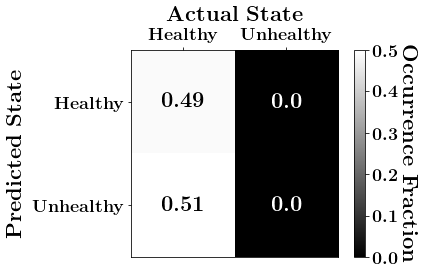

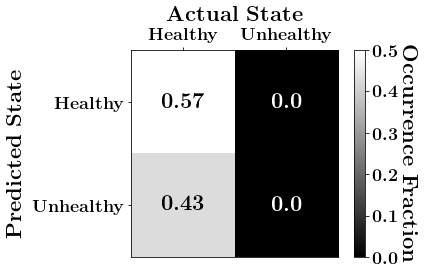

(nan, 0.49, nan)
(nan, 0.57, nan)


In [73]:
# genplt.plot_histogram(model.predict(X_valid_unhealthy[...,np.newaxis])[:,1],[''],
#                'Probability Unhealthy',
#                'Probability Density',
#                'mlp_predict_unhealthy',
#                template='publication',
#                legend_loc='upper right',
#                nbins=50,
#                ymax=0.0,
#                num_col=1)

# genplt.plot_histogram(model.predict(X_valid_healthy[...,np.newaxis])[:,0],[''],
#                'Probability Healthy',
#                'Probability Density',
#                'mlp_predict_healthy',
#                template='publication',
#                legend_loc='upper right',
#                ymax=0.0,
#                nbins=50,
#                num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_cnn_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_cnn_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [37]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[ 7 58]
 [ 5 81]]
0.5827814569536424
[[  2 154]
 [  0 150]]
0.49673202614379086
